In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import traceback
import cvxpy as cp # pip install cvxpy[GUROBI]
import time

## Group Assignment
### Team Number: 6
### Team Member Names: Lakshya, Shrey, Tanisha
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


1. **"Fixing TimeZone Warning"** - Used to remove the timezone warnings after running the check_ticker function.
       https://chatgpt.com/share/67365e1c-fa18-800b-92b9-c9c474055395 
2. Used AI to assist in creating the portfolio vs index graph
3. Used AI to assist in creating the initial strategy and checking over the cvxpy constraints 

**Please ensure that the following library and its corresponding extra package are installed before running the code below!**
- pip install cvxpy
- pip install "cvxpy[GUROBI]"

**Note**

The values in the comments are subject to change as they are dependent on the closing prices the day the code was ran and the time period that was used to get the historical returns of the stock and the indexes. However, the analysis is based upon those prices and reflect our overall thought process. 

## What is our Strategy?

We have decided to go with the **Market Meet** strategy. 
This means that we must create a portfolio which tracks the index average as close as possible for the duration of the testing period.
To do so, we consider the following variables when selecting our most optimal portfolio:
1. Implied Volatility
    - This is a metric which captures the market's view of the likelihood of future changes in a given security's price (Ganti)
2. Beta
    - A measure of systematic risk; we want this value to be as close to 1 as possible for each stock in the portfolio
      - A Beta of 1 indicates that the Stock moves perfectly with the indices
      - Using the formula we learned in class
3. Tracking Error Variance
    - This is the most important variable as it denotes the difference between the price behavriour of a portfolio in comparison to a benchmark.
    - Our goal is to minimize this as much as possible when selecting our optimal portfolio.



------------
###### Ganti, Akhilesh. “How Implied Volatility (IV) Works with Options and Examples.” Investopedia, 2024, www.investopedia.com/terms/i/iv.asp. Accessed 21 Nov. 2024.

‌

This chunk of code pulls the Tickers from the CSV file.
- The tickers are ran through a for loop which selects and removes all delisted and inavlid stocks that it finds.
- The valid tickers left over are then stored in a list.

In [11]:
# Reading the CSV File and assigning the names of a stock to a Column
tickers_df = pd.read_csv('Tickers.csv', names=['Ticker'])
# Converting to a list
tickers_list = tickers_df['Ticker'].tolist()

# Start and end date as per the assignment
start_date = '2023-10-01'
end_date = '2024-09-30'


valid_tickers = [] # Empty list which will store all valid tickers
for ticker in tickers_list:
    try:
        # Check if the ticker has historical data
        data = yf.Ticker(ticker).history(period="1d")
        time.sleep(0.3) 
        if not data.empty:
            valid_tickers.append(ticker)  # Add to valid tickers if data exists
    except Exception as e:
        print(f"Error with ticker {ticker}: {e}")

# Reassigning tickers_list with the ones that are valid
tickers_list = set(valid_tickers)

$ASDFAASDF.TO: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$INVALIDTIC: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$HDFC.NS: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


In [15]:
tickers_list

{'AAPL',
 'ABBV',
 'AMZN',
 'AUST',
 'AW.TO',
 'AXP',
 'BAC',
 'BK',
 'CMCSA',
 'COST',
 'CSCO',
 'CVS',
 'DUOL',
 'GC=F',
 'GM',
 'GOOG',
 'HOOD',
 'IBM',
 'JPM',
 'LOW',
 'ORCL',
 'OXY',
 'PEP',
 'RY.TO',
 'SHOP',
 'SHOP.TO',
 'SLB',
 'SO',
 'SPG',
 'SQ',
 'T.TO',
 'TD.TO',
 'VZ'}

The check_ticker function takes care of the housekeeping details which are necessary to create a valid Portfolio. It filters out the following:
1. Months with less than 18 trading days
2. Stocks that do not meet the monthly volume restriction (of at least 100,000 shares)
3. Stocks traded in currencies that aren't USD or CAD

It cleans up the stock list such that the following algorithms can run without producing errors. 

In [18]:
# check_ticker is a function which checks the validity of a Ticker based on a the following criteria to determine if valid
def check_ticker(ticker):
    try:
        stock_info = yf.Ticker(ticker).info

        # If the stock doesn't trade in USD or CAD
        currency = stock_info.get('currency', None)
        if currency not in ['USD', 'CAD']:
            return None
        
        # Check if the stock is valid and has sufficient data
        if not stock_info or not stock_info.get("symbol"):
            print(f"{ticker} is invalid or does not exist.")
            return None
            
        stock_data = yf.Ticker(ticker).history(period="1y")

        # Checking if any data can be pulled
        if stock_data.empty:
            return None
        
        # AI Usage here (1)
        stock_data.index = stock_data.index.tz_localize(None)
        stock_data['Month'] = stock_data.index.to_period('M')

        # Taking care of the 18+ trading days restriction
        monthly_volume = stock_data.groupby('Month')['Volume'].mean()
        valid_months = stock_data.groupby('Month').size() >= 18
        monthly_volume = monthly_volume[valid_months]
        
        # Taking care of the monthly volume restriction
        if monthly_volume.mean() >= 100_000:
            if not stock_data.empty:
                stock_data = stock_data[['Close']].dropna()
                stock_data.rename(columns={'Close': ticker}, inplace=True)
                return ticker, currency, stock_data

    # Rrror handling
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        traceback.print_exc()
    return None

The use of threading below allows us to run the check_ticker function much faster than simply using a **for loop** and going through each time, by running the function multiple times concurrently instead of sequentially. 
- Reduces time taken to compile the Portfolio.

In [21]:
portfolios = [] # New DataFrame for the portfolios
currencies = {} # New dictionary

# Executes check_ticker in parallel with every ticker to improve performance
# Results are stored in 'currencies' and 'portfolios'
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(check_ticker, ticker) for ticker in tickers_list]
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            currencies[result[0]] = result[1]
            portfolios.append(result[2])

AW.TO: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']


In [23]:
print(currencies)

{'T.TO': 'CAD', 'ORCL': 'USD', 'RY.TO': 'CAD', 'HOOD': 'USD', 'AMZN': 'USD', 'COST': 'USD', 'SQ': 'USD', 'IBM': 'USD', 'ABBV': 'USD', 'SPG': 'USD', 'AXP': 'USD', 'CSCO': 'USD', 'AUST': 'USD', 'BAC': 'USD', 'DUOL': 'USD', 'TD.TO': 'CAD', 'SLB': 'USD', 'LOW': 'USD', 'SHOP': 'USD', 'CMCSA': 'USD', 'OXY': 'USD', 'SO': 'USD', 'CVS': 'USD', 'GM': 'USD', 'VZ': 'USD', 'BK': 'USD', 'PEP': 'USD', 'SHOP.TO': 'CAD', 'JPM': 'USD', 'GOOG': 'USD', 'AAPL': 'USD'}


In [25]:
# Combines the data for all stocks into a single dataframe
stock_p = pd.concat(portfolios, axis=1)
stock_p.dropna(inplace=True)
stock_p.index = stock_p.index.strftime('%Y-%m-%d')
stock_p.index = pd.to_datetime(stock_p.index)

# The total # of stocks selected
num_stocks = len(stock_p.columns)

In [27]:
# Gets the indices data and stores that in a dataframe
idx_p = yf.Tickers(['^GSPC', 'XIU.TO']).history(period="1y", progress=False)
idx_p = idx_p.loc[:, 'Close']
idx_p.dropna(inplace=True)
idx_p.index = idx_p.index.strftime('%Y-%m-%d')
idx_p.index = pd.to_datetime(idx_p.index)

In [29]:
# Calculates the stock and index returns and a matrix of covariances
stock_returns = stock_p.pct_change().dropna()
index_returns = idx_p.pct_change().dropna().mean(axis=1)
stock_returns = stock_returns.loc[index_returns.index]

cov_matrix = stock_returns.cov().to_numpy()
cov_vector = np.array([stock_returns[col].cov(index_returns) for col in stock_returns.columns])
index_variance = index_returns.var()

#print(stock_returns)
#print(cov_vector)

#plt.plot(stock_returns.index, portfolio_value.values, label='Portfolio Value')
#plt.plot(index_value.index, index_value.values, label='Hypothetical Index Value')

The index variance represents the overall volatility of the average returns of the TSX60 and S&P500. For the stocks in the example file provided over the time period we calculated it over, the value we found was 4.678*10^-5, indicating that the indices have an extremely low volatility. This number is what the calc_portfolio_weights function will attempt to match.

The covariance vector stores the covariance between each stock in the list and the index variance. From the example file, it can be seen that the stocks have extremely low covariances with the index, ranging from factors of 10^-4 to 10^-6. It is important to note that the values themselves are percentages so these small covariance values make sense. 

Nonetheless, we can logically take the **highest covariances** out of these values (ie. the ones with the strongest correlation to the index) and weigh them more in comparison to others. 
- This is part of the calculation that is done on the matrices in the calc_portfolio_weights function.

In [32]:
def historical_volatility(ticker):
    # Calculates the volatility based on past stock data
    # Only used if option data is not available
    data = yf.Ticker(ticker).history(period="1y")
    returns = data['Close'].pct_change().dropna()
    volatility = returns.std()
    return volatility * 10


# Takes in a ticker, current date, expiration date
# Returns the average implied volatility for an at-the-money call option and an at the money put option

def implied_volatility(ticker, expiration_date):
    
    us_ticker = ticker.replace('.TO', '')
    stock = yf.Ticker(us_ticker)
    stock_price = stock.history(period="1d")['Close'].iloc[-1]

    try:
        option_chain = stock.option_chain(expiration_date)
    except Exception as e:
        print(f"Could not find options that expire on the date: {expiration_date}", e)
        print(f"Returning historical volatility")
        return historical_volatility(ticker)

    calls = option_chain.calls
    puts = option_chain.puts

    # Takes the difference between the strike price and stock price
    # Argsort returns the index of the option with the smallest difference (closest to being at the money)
    closest_call = calls.iloc[(calls['strike'] - stock_price).abs().argsort()[:1]]
    closest_put = puts.iloc[(puts['strike'] - stock_price).abs().argsort()[:1]]

    # print(closest_call)
    
    try:
        call_iv = closest_call['impliedVolatility'].values[0]
        put_iv = closest_put['impliedVolatility'].values[0]
        avg_iv = pd.Series([call_iv, put_iv]).mean()  
        return avg_iv
    except IndexError:
        print(f"Could not find options that expire on the date: {expiration_date}")
        return None

Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: [2024-12-20, 2025-01-17, 2025-03-21, 2025-04-17, 2025-07-18, 2026-01-16, 2027-01-15]
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: [2024-12-20, 2025-01-17, 2025-04-17, 2025-06-20, 2025-07-18, 2025-09-19, 2025-12-19, 2026-01-16, 2027-01-15]
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: []
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: [2024-12-20, 2025-01-17, 2025-02-21, 2025-05-16, 2026-01-16, 2027-01-15]
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be f

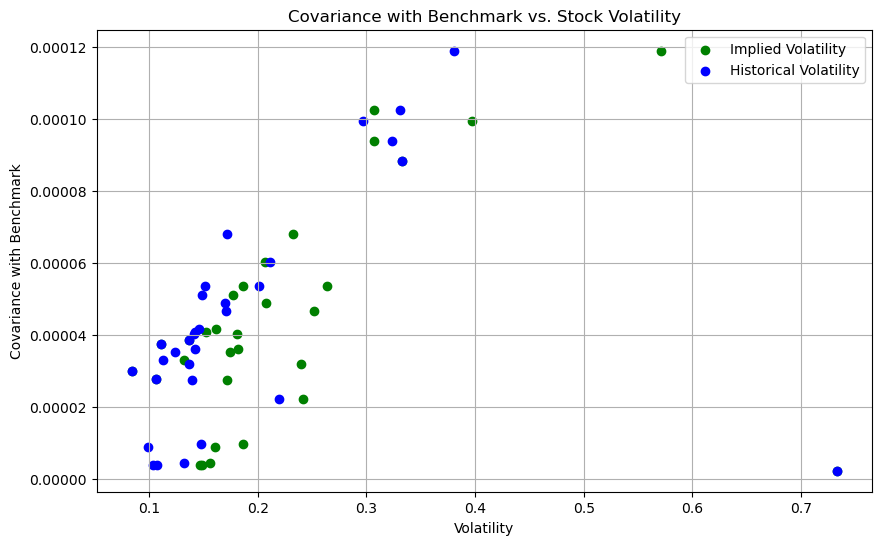

In [34]:
volatilities_i = [implied_volatility(stock, '2024-11-29') for stock in stock_p.columns] # Stores implied volatility
volatilities_h = [historical_volatility(stock) for stock in stock_p.columns] # Stores historical volatility

# Plotting the results to see the difference in behaviour of the stock
plt.figure(figsize=(10, 6))
plt.scatter(volatilities_i, cov_vector, color='green', label='Implied Volatility')
plt.scatter(volatilities_h, cov_vector, color='blue', label='Historical Volatility')
plt.xlabel("Volatility")
plt.ylabel("Covariance with Benchmark")
plt.title("Covariance with Benchmark vs. Stock Volatility")
plt.legend(loc="upper right")  # Adds the legend
plt.grid(True)
plt.show()

#### What does this tell us about how we should pick our ideal stocks for the Portfolio?
At the same time, as per the graph above, we want to **minimize volatility** because the average market indices are less volatile in general. While the trend of the graph appears to skew towards extremely low volatility, stocks that are on the *upper-left to middle-left* should be prioritized by the calc_portfolio_weights function in order to maximize covariance but minimize volatility and therefore minimize error. 
- Further, stocks with extremely low covariance or high volatility should be avoided.

#### How do we handle the Volatility calculations?
The calculations for volatility were based off the **implied volatility** of an at-the-money call and put option. 
- Some stocks do not have options traded on them or trade them less frequently, so as a backup, volatility was simply calculated using the standard deviation of the close prices.
- Instead of doing the historical volatility calculation on all stocks, we used the implied volatilty because it reflects the market's expectations for future price fluctuations; the market has come to a consensus about the future volatility of that stock. 

#### Link to Graph
The graph also reflects this trend; the implied volatility values skew more towards the left because the market expects less volatility in the future than the past, while the historical volatility is all over the place because it simply takes in the standard deviation, which can vary from stock to stock. Additionally, since we're trying to match the S&P500 in the future, the implied volatility makes more sense because it is forward-looking. Additionally, it's interesting that the graph shows that as the volatility (either IV or historical) of a stock increases, it tends to have a slightly higher covariance with the index, which makes sense, as stocks that trade very flat or experience few price movements, may not be well correlated with the indexes, which tend to trend upwards over time.

In [37]:
# An array of implied volatilities as calculated in terms of expiration date
IVs = np.array([implied_volatility(col, '2024-11-29') for col in stock_p.columns])

Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: [2024-12-20, 2025-01-17, 2025-03-21, 2025-04-17, 2025-07-18, 2026-01-16, 2027-01-15]
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: [2024-12-20, 2025-01-17, 2025-04-17, 2025-06-20, 2025-07-18, 2025-09-19, 2025-12-19, 2026-01-16, 2027-01-15]
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: []
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be found. Available expirations are: [2024-12-20, 2025-01-17, 2025-02-21, 2025-05-16, 2026-01-16, 2027-01-15]
Returning historical volatility
Could not find options that expire on the date: 2024-11-29 Expiration `2024-11-29` cannot be f

#### Calculating Beta
The below function calculates the **Beta** of each stock relative to the returns of the indices.
- We want a beta as close as possible to 1, which indicates that the stock moves extremely similarly to the market.
- These values are used in the next function to compare each stock from the list to one another and the benchmark.

In [40]:
# Using the formula from class - the benchmark is the Index Variance
betas = cov_vector / index_variance
print(betas)
#len(betas)

[0.21369264 1.44197289 0.72143173 2.85182875 1.63053307 0.84653152
 2.38638929 0.86873674 0.23545454 0.9234532  1.28214124 0.79544818
 0.054854   1.22193512 2.1150731  0.66645248 1.12062853 0.96267788
 2.45374955 0.66190812 0.7640193  0.09100131 0.53322614 1.28585501
 0.10390357 0.89971211 0.09581627 2.25287644 0.99613982 1.17319894
 0.97703734]


### The Main Function: How we selected the best stocks for our Portfolio
The calc_portfolio_weights function takes in the number of desired stocks (from 12-24), and the Implied Value Constant and Beta constant, and through analysis via cvxpy's GUROBI solver, returning the tracking error variance (TEV) for the optimal selection of each number of stocks. The constants reflect the factors applied to the IV and beta values, which determine their relative importance to the actual TEV.

- In this case, *optimal* means the lowest TEV in comparison with the index returns, meaning that the portfolio with returns closest to the index average returns over the given time period will be chosen. It will then run this for all numbers of stocks between 12-24, and ultimately choose the portfolio which produces the lowest TEV. The TEV, as indicated in the comments below, is based upon the variance of the portfolio returns minus the index returns, which is based upon the known formula of Variance(A-B).
- The constraints that are given to the solver ensure that the weights and the total number of stocks chosen adhere to the given requirements.
- Further, the Implied Volatility of the stock is only weighed using a factor 1e-6 whereas the Beta is weighed with a factor of 1e-5. This is because the Beta of a stock is likely more useful to us as it gives a measurement of the stocks price movements in relation to the index, whereas the IV is simply an expected measure of change in the stocks price over a given time period. These values are rather small, since the actual tracking error tends to be in the magnitude of N*10^-5 or 10^-6, so it has a similar impact on the chosen weights as the tracking error itself.

Once the portfolio is chosen, the rest of the code outputs it to a DataFrame and exports it to csv as per the requirements of the assignment. 
- Some more functions are used to print some statistics and final information about the stocks selected.

In [43]:
# Finds the optimal weights of portfolios
def calc_portfolio_weights(n, IV_const=1e-6, beta_target=1, beta_const=1e-5):
    x = cp.Variable(num_stocks, boolean=True) # whether a stock is included or not
    w = cp.Variable(num_stocks) # the weight of each stock in the portfolio

    # The various constraints we will place on the optimization function
    constraints = [] 

    # Only an n number of stocks should be selected in the portfolio
    constraints.append(cp.sum(x) == n) 

    # Additional weight restrictions
    min_weight_value = 1 / (2 * n)
    max_weight = 0.15

    # Appending that to the constraints list
    constraints += [w >= min_weight_value * x]
    constraints += [w <= max_weight * x]

    # The sum of weights should be equal to 1 and greater than 0
    constraints.append(cp.sum(w) == 1)
    constraints.append(w >= 0)

    # Formula that calculates the tracking error of a matrices
    ''' 
    https://en.wikipedia.org/wiki/Tracking_error
    Var(X - Y) = Var(X) + Var(Y) - 2Cov(X, Y)
    TEV = Var(R_p - R_i) = Var(R_p) - 2 * Cov(R_p, R_i) + Var(R_i)
    w = portfolio weights
    Σ = covariance matrix (n x n)
        - represents the covariance between each pair of assets in the portfolio
    Var(R_p) = w.T @ Σ @ w = quad_form(w, Σ)

    Cov vector = 
    [
        Cov(R_1, R_i),
        Cov(R_2, R_i),
        Cov(R_3, R_i),
        ...
        Cov(R_n, R_i)
    ] where n is the number of assets in the portfolio
     - Multiply by the weight vector to account for the asset weights

    index variance is calculated using pandas
    '''

    # Beta calculation used as a penalty as too low of a Beta is invaluable to our Portfolio
    beta_portfolio = w @ betas
    beta_penalty = beta_const * (beta_portfolio - beta_target)
    
    # The variance between the portfolio return and benchmarking index
    tracking_error_variance = cp.quad_form(w, cov_matrix) - 2 * w @ cov_vector + index_variance

    # Implied Volatility used as a penalty as a stock that is too volatile as not valuable to our Portfolio
    IV_penalty = IV_const * w @ IVs
    
    # what we want the cvxpy analysis to do, which is minimize the variance and implied-volatility penalty
    objective = cp.Minimize(tracking_error_variance + IV_penalty + beta_penalty)

    # this command summarizes the problem in one step, adding the constraints as well
    problem = cp.Problem(objective, constraints)

    try:
        # Solving the problem
        problem.solve(solver=cp.GUROBI)
    except:
        problem.solve()

    # When the problem is at optimal status, return the ideal values
    if problem.status == cp.OPTIMAL:
        cur_TEV = problem.value
        solution = (w.value, x.value)
        return cur_TEV, solution 
    else:
        return None
        

In [45]:
solutions = {}

# Use threading to run the function for every value of n from 12-24, to find the optimal value
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(calc_portfolio_weights, i) for i in range(12, 25)]
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            solutions[result[0]] = result[1]


Restricted license - for non-production use only - expires 2026-11-23


In [47]:
# Takes the solution with the smallest variance
min_TEV = min(solutions)
best_solution = solutions[min_TEV]

# Finds the optimal weights and optimal stocks
optimal_weights = best_solution[0]
optimal_selection = best_solution[1]

# The final selected parameters
selected_indices = [i for i, val in enumerate(optimal_selection) if val > 0.5]
selected_stocks = stock_p.columns[selected_indices].tolist()
selected_weights = optimal_weights[selected_indices]

# The final portfolio dataframe
portfolio = pd.DataFrame({
    'Ticker': selected_stocks,
    'Weight': selected_weights
})

print("Optimal number of stocks (n):", len(selected_indices))
print("Tracking Error Variance:", min_TEV)
print("Selected Portfolio:")
portfolio

Optimal number of stocks (n): 21
Tracking Error Variance: 5.995670804480991e-06
Selected Portfolio:


,Ticker,Weight
0,T.TO,0.066629
1,ORCL,0.031228
2,RY.TO,0.150000
3,AMZN,0.065889
4,COST,0.082225
5,IBM,0.023810
6,ABBV,0.023810
7,AXP,0.023810
8,DUOL,0.023810
9,TD.TO,0.085044


In [50]:
# Starting parameters
investment = 1_000_000
testing_start_date = '2024-11-22'
testing_end_date = '2024-11-23'

tickers = portfolio['Ticker'].tolist()
prices = {}

for ticker in tickers:
    price = yf.Ticker(ticker).history(period="1d")
    if not price.empty:
        prices[ticker] = price['Close'].iloc[0]

# Exchange rate conversions
fx = yf.Ticker('CADUSD=X').history(start=start_date, end=end_date)
if not fx.empty:
    cad_to_usd = fx['Close'].iloc[0]

This function just provides some **descriptive statistics** about the Portfolio, like its average weight in each stock, the total # of stocks selected and the ones with the most and least weights.

In [53]:
def portfolio_stats(pf):
    print("Portfolio Statistics:")
    print(f"Number of stocks in Portfolio: {len(pf)}")
    print(f"Average Weight of Each Stock: {(pf['Weight'].mean()*100):.2f}%")
    print(f"Largest Weight: {pf['Ticker'][pf['Weight'].idxmax()]} "
          f"({pf['Weight'].max()*100:.2f}%)")
    print(f"Smallest Weight: {portfolio['Ticker'][pf['Weight'].idxmin()]} "
          f"({pf['Weight'].min()*100:.2f}%)")

portfolio_stats(portfolio)

Portfolio Statistics:
Number of stocks in Portfolio: 21
Average Weight of Each Stock: 4.76%
Largest Weight: RY.TO (15.00%)
Smallest Weight: IBM (2.38%)


The **standardize_price** function ensures returns the CAD closing price of all the stocks and is used in further calculations. The rest of the code ensures that the total is $\$1000000$, as expected. It also calculates the following:
- Portfoltio Weights
- Portfolio Value
- Fees charged
- Total Spent

In [56]:
def standardize_price(ticker, currency):
    domestic_price = prices[ticker]

    if currency == 'USD':
        return domestic_price / cad_to_usd
    else:
        return domestic_price
    

portfolio['Price'] = portfolio['Ticker'].map(prices)
portfolio['Currency'] = portfolio['Ticker'].map(currencies)
portfolio['Price_CAD'] = portfolio.apply(lambda x: standardize_price(x['Ticker'], x['Currency']), axis=1)
portfolio['Value'] = investment * portfolio['Weight']

portfolio['Shares'] = portfolio['Value'] / portfolio['Price_CAD']
portfolio['Fee'] = portfolio['Shares'].apply(lambda x: min(3.95, 0.001 * x))
portfolio['Value'] -= portfolio['Fee']
portfolio['Shares'] = portfolio['Value'] / portfolio['Price_CAD']
portfolio['Value'] = portfolio['Shares'] * portfolio['Price_CAD']
portfolio['Weight'] = portfolio['Value'] / portfolio['Value'].sum()

portfolio.index += 1

info = f'''
The sum of weights is {portfolio['Weight'].sum()}
The total portfolio value is ${np.round(portfolio['Value'].sum(), 2)}
plus fees of ${np.round(portfolio['Fee'].sum(), 2)}
to give a total of ${np.round(portfolio['Value'].sum() + portfolio['Fee'].sum(), 2)}
'''
print(info)


The sum of weights is 1.0
The total portfolio value is $999991.04
plus fees of $8.96
to give a total of $1000000.0



This is the Final Portfolio containing all the selected stocks, their weights, prices and other information.

In [59]:
Portfolio_Final = portfolio.loc[:,['Ticker','Price','Currency','Shares','Value','Weight']]
Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight
1,T.TO,21.545000,CAD,3092.397244,66625.698849,0.066626
2,ORCL,190.136002,USD,120.997960,31227.748157,0.031228
3,RY.TO,174.660004,CAD,858.806470,149999.141189,0.150000
4,AMZN,200.837494,USD,241.695980,65888.934194,0.065890
5,COST,954.690002,USD,63.451965,82225.346887,0.082226
6,IBM,224.899994,USD,77.994069,23809.445815,0.023810
7,ABBV,177.414993,USD,98.869042,23809.424940,0.023810
8,AXP,304.489990,USD,57.607413,23809.466202,0.023810
9,DUOL,345.510010,USD,50.768097,23809.473041,0.023810
10,TD.TO,78.699997,CAD,1080.599044,85043.141453,0.085044


After adjusting for fees, some of the weights may be extremely slightly above or below the given weight limits. 

For one portfolio produced using the example Tickers file, the results make intuitive sense. For one, stocks are fairly equally weighted; since the market is so diversified, it makes sense to include a variety of stocks from a variety of industries in order to simulate the market. 
- An interesting observation can also be made; the RBC and TD Bank stocks make up nearly a quarter of the portfolio alone (on the Example Tickers file)
  - This can be attributed to the fact that stocks in the financial industry tend to be very stable -- this was also seen in Assignment 3. 

In [63]:
Stocks_Final = portfolio[['Ticker', 'Shares']]
filename = f"Stocks_Group_06.csv"
Stocks_Final.to_csv(filename)

In [65]:
# Calculates the ratio of returns between the index and the selected portfolio

index_cumulative_returns = [1]  
stock_cumulative_returns = [1]

# Calculates the cumulative returns on a day by day basis
for i in range(1, len(index_returns)):
    new_index_return = index_cumulative_returns[-1] * (1 + index_returns.iloc[i])
    index_cumulative_returns.append(new_index_return)
    
    weighted_stock_return = (stock_returns[selected_stocks].iloc[i] * selected_weights).sum()
    new_stock_return = stock_cumulative_returns[-1] * (1 + weighted_stock_return)
    stock_cumulative_returns.append(new_stock_return)

ratio = []
for i in range(1, len(index_returns)):
    ratio.append(stock_cumulative_returns[i]/index_cumulative_returns[i])

avg_ratio = sum(ratio)/len(ratio)

print("Average Ratio:", round(avg_ratio, 4))
print("Portfolio Final Value:", stock_cumulative_returns[-1])
print("Index Final Value:", index_cumulative_returns[-1])

Average Ratio: 1.0101
Portfolio Final Value: 1.3384056531211854
Index Final Value: 1.3094500006730772


We want Average Ratio here to be as close to 1 as possible since we want the Portfolio's to perform similarly to the Index and thus, a ratio of 1:1 would indicate that the stocks move perfectly in sync. 
- The closer the value is to one, the better the Portfolio meets the index average.

In [68]:
# Converts between currencies
def convert_price(price, currency):
    if currency == 'USD':
        return price / cad_to_usd
    else:
        return price

def compare_portfolio_to_index(portfolio_df, initial_investment, start_date, end_date):
    """
    Compare the performance of a custom stock portfolio to a hypothetical index.

    Parameters:
    - portfolio_df: DataFrame with columns ['Ticker', 'Shares'].
    - initial_investment: float, initial amount invested in the hypothetical index.
    - start_date: str or datetime, start date of the analysis.
    - end_date: str or datetime, end date of the analysis.

    Returns:
    - None (plots the portfolio value and index value over time).
    """
    # Ensure the Ticker column is of string type
    portfolio_df['Ticker'] = portfolio_df['Ticker'].astype(str)
    
    # Get list of tickers and shares
    tickers = portfolio_df['Ticker'].tolist()
    shares = portfolio_df['Shares'].tolist()
    portfolio = dict(zip(tickers, shares))

    # Download historical price data for portfolio stocks
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
    
    # Multiply the stock prices by the number of shares to get daily portfolio value
    for ticker in tickers:
        stock_data[ticker] = convert_price(stock_data[ticker], currencies[ticker]) * portfolio[ticker]

    # Sum the values to get total portfolio value over time
    portfolio_value = stock_data.sum(axis=1)
    
    # Download historical price data for S&P 500 and TSX 60 ETFs
    # Using SPY (S&P 500 ETF) and XIU.TO (iShares S&P/TSX 60 ETF)
    index_tickers = ['^GSPC', 'XIU.TO']
    index_data = yf.download(index_tickers, start=start_date, end=end_date)['Close']

    # Normalize the index prices to start at the same point
    index_norm = index_data / index_data.iloc[0]

    # Calculate the average normalized index value
    index_avg = index_norm.mean(axis=1)

    # Scale the index average by the initial investment
    index_value = index_avg * initial_investment

    # Plot the portfolio value and index value over time
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value')
    plt.plot(index_value.index, index_value.values, label='Average Index Value')
    plt.title('Portfolio vs. Average Index Performance')
    plt.xlabel('Date')
    plt.ylabel('Total Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

/var/folders/zx/cvsff535573fwf34y7tg7jhh0000gn/T/ipykernel_11636/3650125714.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df['Ticker'] = portfolio_df['Ticker'].astype(str)
[*********************100%***********************]  21 of 21 completed
[*********************100%***********************]  2 of 2 completed


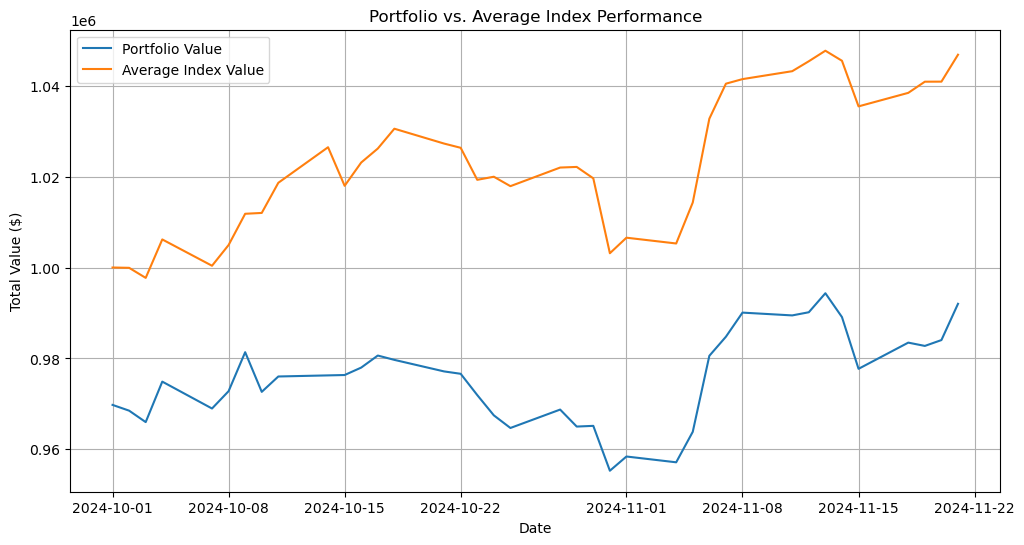

In [70]:
compare_portfolio_to_index(Stocks_Final, investment, '2024-10-01', '2024-11-22')

Note: The discrepancy between the Portfolio and Index Values occurs due to the fact that the close prices are pulled on November 22nd, 2024, which is what the number of shares for each stock is based upon, whereas the data is graphed starting on October 1st, 2024
- However, it is evident that the values still move relatively in sync with one another.

From the graph and the avg_ratio calculated above, the model is extremely accurate over the time period of October 1, 2024 to November 14, 2024, for the given example tickers file. The average ratio is 1.018, meaning that the model is off by approximately 1.01%. 

Additionally, the time period chosen has resulted in there being increased market volatility overall, thanks to the U.S. general election and the surge and decline of various stocks as a result of the Republican majority. 
- This heightened market volatility provides an excellent test for the model, as it is being applied during a period of rather unpredictable stock behaviours and yet, managed to perform pretty well.
- Despite the fluctuations caused by the election, the model's average error was low, showcasing that it was effective in predicting stock trends!

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Lakshya, Shrey, Tanisha